In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor


pd.set_option('display.max_columns', None)


In [2]:
!ls *.csv

exercice_data.csv


In [3]:
df = pd.read_csv("exercice_data.csv", sep=None, encoding='latin1')
df.head()

/tmp/ipykernel_5013/4032176105.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("exercice_data.csv", sep=None, encoding='latin1')


,StudentID,FirstName,FamilyName,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,FinalGrade
0,0,Rafael,Morais,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,6
1,1,Lara,Braga,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,6
2,2,Gonçalo,Azevedo,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,10
3,3,Lara,Perna,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15
4,4,João,Pires,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,10


In [4]:
df.shape

(357, 33)

In [5]:
df.isna().sum()

StudentID     0
FirstName     0
FamilyName    0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
FinalGrade    0
dtype: int64

In [6]:
df.Medu.value_counts()

Medu
4    125
3     90
2     89
1     50
0      3
Name: count, dtype: int64

In [7]:
df.address.value_counts()

address
U    279
R     78
Name: count, dtype: int64

# Model 

In [8]:
# Define a dictionary to map "yes" to 1 and "no" to 0
replace_dict = {"yes": 1, "no": 0}

# Replace "yes" and "no" with 1 and 0 in the entire DataFrame
df.replace(replace_dict, inplace=True)

/tmp/ipykernel_5013/1804370698.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replace_dict, inplace=True)


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define columns to apply one-hot encoding
columns_to_encode = ['sex', 'address', 'famsize', 'Pstatus', 'reason', 'guardian', 'Mjob', 'Fjob']

# Define transformer for one-hot encoding
encoder = OneHotEncoder(drop='first')

# Define preprocessor for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', encoder, columns_to_encode)
    ],
    remainder='passthrough'
)

# Define pipeline with preprocessor and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        random_state=42,
        n_estimators=100,  # Number of trees in the ensemble
        max_depth=2,  # Maximum depth of each tree
        learning_rate=0.1,  # Step size shrinkage used in update to prevent overfitting
        min_child_weight=1,  # Minimum sum of instance weight (hessian) needed in a child
        subsample=0.8,  # Subsample ratio of the training instance
        colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
        reg_alpha=0,  # L1 regularization term on weights
        reg_lambda=1,  # L2 regularization term on weights
        gamma=0,  # Minimum loss reduction required to make a further partition on a leaf node of the tree
        ))
])

# Split data into features and target variable
X = df.drop(columns=['FinalGrade', 'StudentID', 'FirstName', 'FamilyName'])
y = df['FinalGrade'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model on the training set
pipeline.fit(X_train, y_train)

# Retrieve feature importance
feature_importance = pipeline.named_steps['model'].feature_importances_

# Sort feature importance in descending order
sorted_idx = np.argsort(feature_importance)[::-1]

# Select top N features
top_features = sorted_idx[:15]  # Change 10 to the number of top features you want to select

# Print the number of columns in X and the length of top_features
print("Number of columns in X:", len(X.columns))
print("Length of top_features:", len(top_features))

# Retrieve feature names after one-hot encoding
one_hot_encoded_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(input_features=columns_to_encode)
remaining_feature_names = [col for col in X.columns if col not in columns_to_encode]
feature_names = list(one_hot_encoded_feature_names) + remaining_feature_names

# Print top features if there are no issues with indices
if len(top_features) <= len(feature_names):
    print("Top 10 features:")
    for i in top_features:
        print(feature_names[i])
else:
    print("Error: Top feature indices exceed the number of columns after one-hot encoding.")

Number of columns in X: 29
Length of top_features: 15
Top 10 features:
failures
schoolsup
Mjob_services
Fjob_teacher
absences
health
internet
Walc
studytime
Dalc
reason_other
famsize_LE3
freetime
goout
sex_M


In [14]:
# Make predictions on both train and test sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Calculate evaluation metrics for train set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate evaluation metrics for test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae],
    'R2': [train_r2, test_r2],
    'MSE': [train_mse, test_mse]
})

/home/adelchiasta/venv/venv_ekinox/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/adelchiasta/venv/venv_ekinox/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
metrics_df

,Set,RMSE,MAE,R2,MSE
0,Train,2.100633,1.695108,0.579648,4.412659
1,Test,2.856834,2.308550,0.192819,8.161498


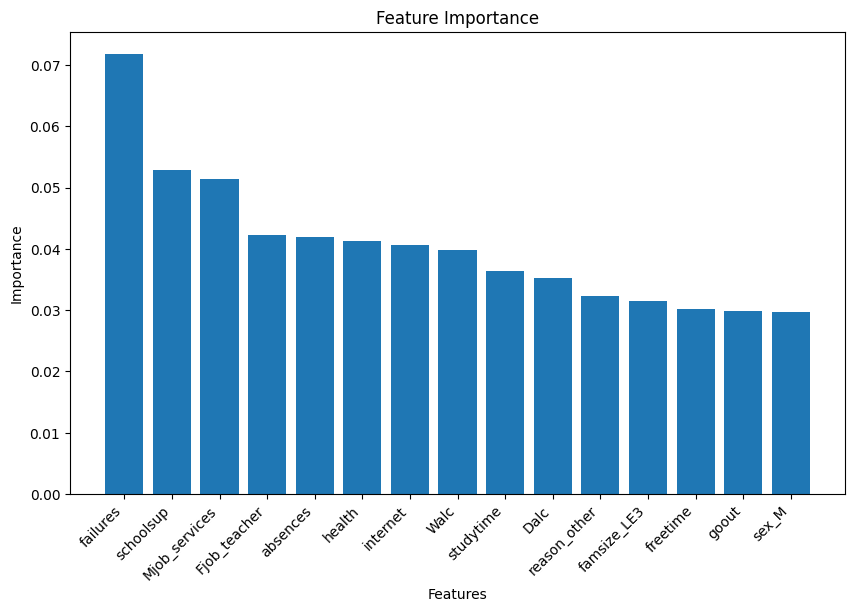

In [16]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(top_features)), feature_importance[top_features], align="center")
plt.xticks(range(len(top_features)), [feature_names[i] for i in top_features], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


## Composite score 

In [49]:
# # Select only numerical columns for normalization
numerical_data = df.select_dtypes(include=['number'])
# Normalize each indicator to a scale of 0 to 1
max_values = numerical_data.max()
min_values = numerical_data.min()
normalized_data = (numerical_data - min_values) / (max_values - min_values)

# Retrieve feature names after one-hot encoding
one_hot_encoded_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(input_features=columns_to_encode)
remaining_feature_names = [col for col in X.columns if col not in columns_to_encode]
feature_names = list(one_hot_encoded_feature_names) + remaining_feature_names

# Update the weights based on feature importances
weights = dict(zip([feature_names[i] for i in top_features], feature_importance[top_features]))

# Normalize the weights
total_importance = sum(weights.values())
for feature in weights:
    weights[feature] /= total_importance

# Compute the composite score using the updated weights
composite_score = (normalized_data * pd.Series(weights)).sum(axis=1)

# Add the composite score as a new column to your DataFrame
df['composite_score'] = composite_score

In [50]:
weights

{'failures': 0.11825925619861061,
 'schoolsup': 0.08709928865177899,
 'Mjob_services': 0.08459508568157457,
 'Fjob_teacher': 0.06954763192797934,
 'absences': 0.06899698112695013,
 'health': 0.06788748604719026,
 'internet': 0.06692290811760764,
 'Walc': 0.06554818372034356,
 'studytime': 0.060020955724493334,
 'Dalc': 0.05801396489588255,
 'reason_other': 0.053130081404226315,
 'famsize_LE3': 0.05199398053732354,
 'freetime': 0.04971951408945669,
 'goout': 0.04927864668347218,
 'sex_M': 0.04898603519311028}